## Learning Text Similarity with Siamese Recurrent Networks

https://aclanthology.org/W16-1617.pdf

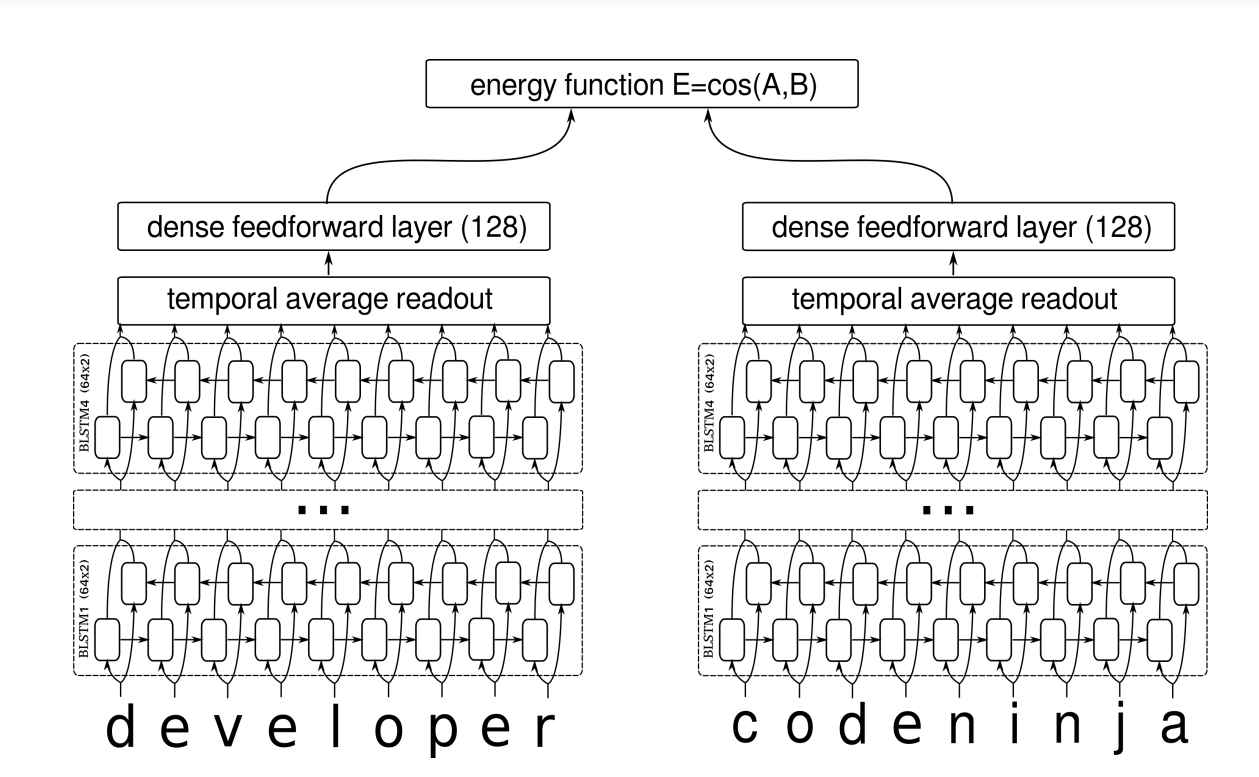

In [44]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model
from keras import layers
from keras import backend as K
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
import tensorflow as tf

In [35]:
def prepare_dataset(path):
    df = pd.read_csv(path, sep='\t', lineterminator='\n',header=None)
    df = df.rename(columns = {0:'name1',1:'name2',3:'label'})
    x1 = []
    x2 = []
    label = []
    name1 = df.name1.values.tolist()
    name2 = df.name2.values.tolist()
    for n1,n2 in zip(name1,name2):
        if random.random()>0.5:
            x1.append(n1)
            x2.append(n2)
        else:
            x1.append(n2)
            x2.append(n1)
        label.append(1)
    all_name = np.asarray(name1+name2)
    shuffle_name = all_name[np.random.permutation(np.arange(len(all_name)))]
    for n1,n2 in zip(all_name,shuffle_name):
        if random.random()>0.5:
            x1.append(n1)
            x2.append(n2)
        else:
            x1.append(n2)
            x2.append(n1)
        label.append(0)
    return pd.DataFrame({'name1':x1,'name2':x2,'label':label})

In [36]:
df = prepare_dataset('person_match.train2')

In [37]:
MAX_SEQ_LEN = 70


In [38]:
def prepere_training_data(df,tokenizer):
    name1_seq = tokenizer.texts_to_sequences(df['name1'])
    name2_seq = tokenizer.texts_to_sequences(df['name2'])

    name1_seq = pad_sequences(name1_seq,maxlen=MAX_SEQ_LEN)
    name2_seq = pad_sequences(name2_seq,maxlen=MAX_SEQ_LEN)
    return name1_seq,name2_seq,df['label'].values

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['name1'])
train,test = train_test_split(df,test_size=0.2,stratify = df['label'])
train_text2seq_1,train_text2seq_2,train_label = prepere_training_data(train,tokenizer)
test_text2seq_1,test_text2seq_2,test_label = prepere_training_data(test,tokenizer)


## Model

In [45]:

num_word = len(tokenizer.word_index)+1
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def cosine_distanct(vests):
    x,y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cosine_distanct_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

embdding_layer = layers.Embedding(num_word,output_dim=16,mask_zero=False)

lstm_layer_1 = layers.Bidirectional(layers.LSTM(64,return_sequences=True))
lstm_layer_2 = layers.Bidirectional(layers.LSTM(64,return_sequences=True))

inp_seq1 = layers.Input(shape=(MAX_SEQ_LEN,))
inp_seq2 = layers.Input(shape=(MAX_SEQ_LEN,))

x1 = embdding_layer(inp_seq1)
# print(x1.shape)
x1 = lstm_layer_1(x1)
# print(x1.shape)

x1 = lstm_layer_2(x1)
x1 = layers.GlobalAveragePooling1D()(x1)
x1 = layers.Dense(128)(x1)

x2 = embdding_layer(inp_seq2)
x2 = lstm_layer_1(x2)
x2 = lstm_layer_2(x2)
x2 = layers.GlobalAveragePooling1D()(x2)
x2 = layers.Dense(128)(x2)

merge = layers.Lambda(euclidean_distance)([x1, x2])
merge = layers.BatchNormalization()(merge)
out = layers.Dense(1,activation='sigmoid')(merge)

model = Model(inputs=[inp_seq1,inp_seq2],outputs = out)
opt = SGD(lr=0.01)
# model.compile(optimizer=opt,loss='binary_crossentropy',metrics='acc')
# model.fit([train_text2seq_1,train_text2seq_2,],train_label,epochs=5,batch_size=64,verbose=1,
#           validation_data=([test_text2seq_1,test_text2seq_2],test_label))

c:\Users\ujjal\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [50]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)


        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [51]:
margin =1
model.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  


 input_37 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 70, 16)       1216        ['input_36[0][0]',               
                                                                  'input_37[0][0]']               
                                                                                                  
 bidirectional_25 (Bidirectiona  (None, 70, 128)     41472       ['embedding_20[0][0]',           
 l)                                                               'embedding_20[1][0]']           
                                                                                                  
 bidirectional_26 (Bidirectiona  (None, 70, 128)     98816       ['bidirectional_25[0][0]',       
 l)                                                               'bidirectional_25[1][0]']       
          

In [52]:
model.fit([train_text2seq_1,train_text2seq_2,],train_label,epochs=5,batch_size=64,verbose=1,
          validation_data=([test_text2seq_1,test_text2seq_2],test_label))

Epoch 1/5
 37/495 [=>............................] - ETA: 5:38 - loss: 0.2487 - accuracy: 0.5389

KeyboardInterrupt: 